# Importing Data

In [ ]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd

!pip install keras_tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


Useful function to define for later visualization purposes

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the confusion matrix
def plot_confusion_matrix(y_pred_proba, y_test):
    y_pred = (y_pred_proba > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot accuracy and loss through epochs
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot training & validation accuracy values on the first axis
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values on the second axis
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='upper left')

    # Display the plots
    plt.tight_layout()  # Adjusts spacing to prevent overlap
    plt.show()

Here I will connect to my google drive in order to be able to save partial results during the training process and skip some training time sometimes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive")

In [ ]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://raw.githubusercontent.com/Oxke/DL-Project/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(f'{target_folder}/input_data.pkl', 'rb') as f:
    dd = pk.load(f)

X = dd['X']
y = dd['y']

In [ ]:
X.shape, y.shape

((303, 13), (303, 1))

In [ ]:
X[0]

array([ 63. ,   1. ,   3. , 145. , 233. ,   1. ,   0. , 150. ,   0. ,
         2.3,   0. ,   0. ,   1. ])

# Preprocessing

The next code is needed to understand for each feature whether it's a cathegorical or numerical one

In [ ]:
for i in range(X.shape[1]):
    print(f"Feature {i} has {np.unique(X[:,i]).shape[0]} unique values from {X[:,i].min()} to {X[:,i].max()}")

Feature 0 has 41 unique values from 29.0 to 77.0
Feature 1 has 2 unique values from 0.0 to 1.0
Feature 2 has 4 unique values from 0.0 to 3.0
Feature 3 has 49 unique values from 94.0 to 200.0
Feature 4 has 152 unique values from 126.0 to 564.0
Feature 5 has 2 unique values from 0.0 to 1.0
Feature 6 has 3 unique values from 0.0 to 2.0
Feature 7 has 91 unique values from 71.0 to 202.0
Feature 8 has 2 unique values from 0.0 to 1.0
Feature 9 has 40 unique values from 0.0 to 6.2
Feature 10 has 3 unique values from 0.0 to 2.0
Feature 11 has 5 unique values from 0.0 to 4.0
Feature 12 has 4 unique values from 0.0 to 3.0


So we see that
- Features 1, 5, 8 are categorical of binary output, and the domain is already \{0, 1\} so I won't modify them
- Features 2, 6, 10, 11, 12 are categorical with, respectively, 4, 3, 3, 5, 4 outcomes, and will be one-hot coded
- Features 0, 3, 4, 7, 9 are numerical and will be scaled to [0, 1]

In [ ]:
class Preprocessing:
    def __init__(self, num_scale, cat_one_hot):
        self.num_scale = num_scale
        self.cat_one_hot = cat_one_hot

    def _scaler(self, x):
        min_num = tf.reduce_min(x, axis=0)
        max_num = tf.reduce_max(x, axis=0)
        res = tf.math.divide(tf.math.subtract(x, min_num),
                              tf.math.subtract(max_num, min_num))
        return tf.cast(res, tf.float64)

    def _one_hot(self, x):
        """
        Takes as input the sequence of categorical data and returns
        the one-hot encoded version. It also returns a list of lists
        `list_groups` which contains the indices of the each categorical feature
        in the one-hot encoded version. This will be used in the inspection to
        reconstruct the total influence of the feature
        """
        x = tf.cast(x, tf.int32)
        res = []
        for i in range(x.shape[1]):
            one_hot = tf.one_hot(x[:, i], depth=tf.reduce_max(x[:, i]) + 1)
            res.append(one_hot)
        list_groups = []
        j = 0
        for i in range(len(res)):
            list_groups.append(list(range(j, j + res[i].shape[1])))
            j += res[i].shape[1]
        return tf.cast(tf.concat(res, axis=1), tf.float64), list_groups


    def __call__(self, inputs):
        numerical_data = tf.gather(inputs, self.num_scale, axis=1)
        categorical_data = tf.gather(inputs, self.cat_one_hot, axis=1)
        remaining = [i for i in range(inputs.shape[1]) \
                    if i not in self.num_scale and i not in self.cat_one_hot]
        remaining_data = tf.gather(inputs, remaining, axis=1)

        scaled_num_data = self._scaler(numerical_data)

        one_hot_encoded, list_groups = self._one_hot(categorical_data)

        processed_inputs = tf.concat([one_hot_encoded, scaled_num_data,
                                    remaining_data], axis=1)
        return processed_inputs, list_groups

num_features_to_scale = [0, 3, 4, 7, 9]
cat_features_to_one_hot = [2, 6, 10, 11, 12]

# create the preprocessing instance (used like a function)
preprocessing = Preprocessing(num_features_to_scale, cat_features_to_one_hot)

In [ ]:
print(X.shape, end=' -> ')
X, list_groups = preprocessing(X)
print(X.shape)

(303, 13) -> (303, 27)


Finally we split the data into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, test_size=0.05, random_state=42)

# Define model shape
Here I will define the general shape of the model, as I've imagined doing in the written exam, and I will try training one particular configuration. In the later section I will random search for a better configuration of hyperparameters.

In [ ]:
lambda_L2 = 0.01
depth = 3
n_first = 50
n_next = 10
dropout = 0.2
activation = 'relu'

def make_model(input_units, lambda_L2, depth, n_first, n_next, dropout, activation):
    l2_reg = keras.regularizers.l2(lambda_L2)
    inputs = keras.Input(shape=(input_units,), name="InputLayer")
    x = layers.Dense(n_first, activation=activation,
                     kernel_regularizer=l2_reg,
                     name="FC_first_overcomplete")(inputs)
    for i in range(depth):
        x = layers.Dense(n_next, activation=activation,
                         kernel_regularizer=l2_reg,
                         name=f"FC_{i+1}a")(x)
        x = layers.Dense(n_next, activation=activation,
                         kernel_regularizer=l2_reg,
                         name=f"FC_{i+1}b")(x)
        x = layers.Dropout(dropout, name=f"Dropout_{i+1}")(x)
    outputs = layers.Dense(1, activation='sigmoid', name="OutputLayer")(x)
    return keras.Model(inputs=inputs, outputs=outputs)

model = make_model(X.shape[1], lambda_L2, depth, n_first, n_next, dropout, activation)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_first_overcomplete (Dense)        │ (None, 50)                  │           1,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1a (Dense)                        │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1b (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_2a (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_2b (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_3a (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_3b (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,471 (9.65 KB)

 Trainable params: 2,471 (9.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0)

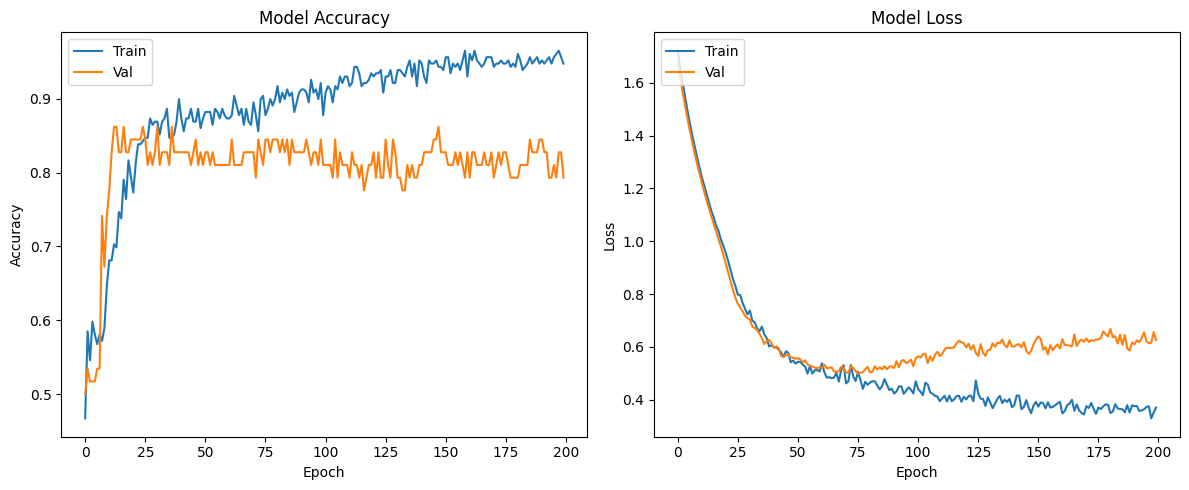

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8125 - loss: 0.8864


[0.886361837387085, 0.8125]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


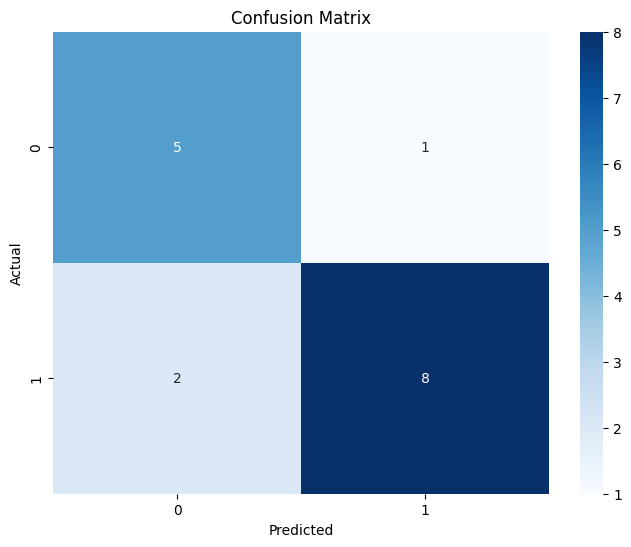

In [ ]:
plot_confusion_matrix(model.predict(X_test), y_test)

# Model Selection
Now we will perform hyperparameter optimization using Random Search on:
- L2's $\lambda$
- number of cycles of 2*FC + Dropout
- Dropout value
- number of units in the first hidden layer
- number of nodes in the other hidden layers
- learning rate
- activation function (`ReLU` vs `sigmoid`)

Finally we will optimize the number of epochs by implementing a callback that stops the training once the validation loss stops improving

In [ ]:
def build_model(hp):
    # Create the model
    n_inputs = 27
    lambda_L2 = hp.Float('lambda_L2', min_value=1e-5, max_value=1, sampling='log')
    depth = hp.Int('depth', min_value=1, max_value=5, step=1)
    n_first = hp.Int('n_first', min_value=10, max_value=100, sampling='log')
    n_others = hp.Int('n_others', min_value=5, max_value=50, sampling='log')
    dropout = hp.Float('dropout', min_value=0.1, max_value=0.5)
    activation = hp.Choice('activation', values=['relu', 'sigmoid'])

    model = make_model(n_inputs, lambda_L2, depth, n_first, n_others, dropout, activation)

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


having implemented it in keras, I have to manually define the cross validation I want to perform

> note: in the written exam I wrote "cross-validation during training", I obviously meant during hyperparameter optimization. Indeed I have it here.

In [ ]:
from sklearn.model_selection import KFold
def cross_validate(X, y, tuner, k, epochs=10, callbacks=[]):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_results = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        print(f"Training fold {fold_no}...")

        # Perform hyperparameter search
        tuner.search(X_train, y_train, epochs=epochs,
                     callbacks=callbacks,
                     validation_data=(X_val, y_val))

        # Retrieve the best model for this fold
        best_model = tuner.get_best_models(num_models=1)[0]

        # Evaluate the best model on the validation set
        val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
        print(f"Fold {fold_no} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        all_results.append((best_model, best_hps, val_loss, val_accuracy))
        fold_no += 1

    return all_results

Now I'll define the tuner

In [ ]:
# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=500,
    # overwrite=True, # for now
    directory='DL-exam',
    project_name='RandSearchCV',
    seed=312,
)

And finally we can run the search

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

In [ ]:
results = cross_validate(X_train, y_train,
                         tuner, k=5, epochs=100,
                         callbacks=[early_stopping])

best_model, best_hps = max(results, key=lambda x: x[3])[0:2]

print(f"Best Hyperparameters: {best_hps.values}")
with open('DL-exam/best_hps.pkl', 'wb') as f:
    pk.dump(best_hps, f)
best_model.save("DL-exam/best_model.keras")

Trial 500 Complete [00h 00m 22s]
val_accuracy: 0.8448275923728943

Best val_accuracy So Far: 0.931034505367279
Total elapsed time: 02h 38m 16s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9124 - loss: 0.5438 
Fold 1 - Validation Loss: 0.5387310981750488, Validation Accuracy: 0.931034505367279
Training fold 2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7568 - loss: 0.6002 
Fold 2 - Validation Loss: 0.5951620936393738, Validation Accuracy: 0.7758620977401733
Training fold 3...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8284 - loss: 0.5468 
Fold 3 - Validation Loss: 0.5595225095748901, Validation Accuracy: 0.7894737124443054
Training fold 4...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8660 - loss: 0.5645 
Fold 4 - Validation Loss: 0.5547976493835449, Validation Accuracy: 0.8771929740905762
Training fold 5...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8986 - loss: 0.5475 
Fold 5 - Validation Loss: 0.5444509387016296, Validation Accuracy: 0.8947368264198303
Best Hyperparameters: {'lambda_L2': 4.188066830810698e-05, 'depth': 1, 'n_first': 12, 'n_others': 34, 'dropout': 0.220632435606165, 'activation': 'relu', 'learning_rate': 0.0005428659940212535}


### Final performances

notably the model is relatively small, with only one cycle of 2FC + Dropout, and the best number of units found between the 500 tried trials was actually one where the first hidden layer has less nodes and the others have more then the input layer, which is slightly unexpected, but we will see later in inspection if it most nodes are actually used in the 34 or just few are of importance.

In [ ]:
model = keras.models.load_model("DL-exam/best_model.keras")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_first_overcomplete (Dense)        │ (None, 12)                  │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1a (Dense)                        │ (None, 34)                  │             442 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1b (Dense)                        │ (None, 34)                  │           1,190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 34)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 1)                   │              35 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.5643


[0.564272403717041, 0.875]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


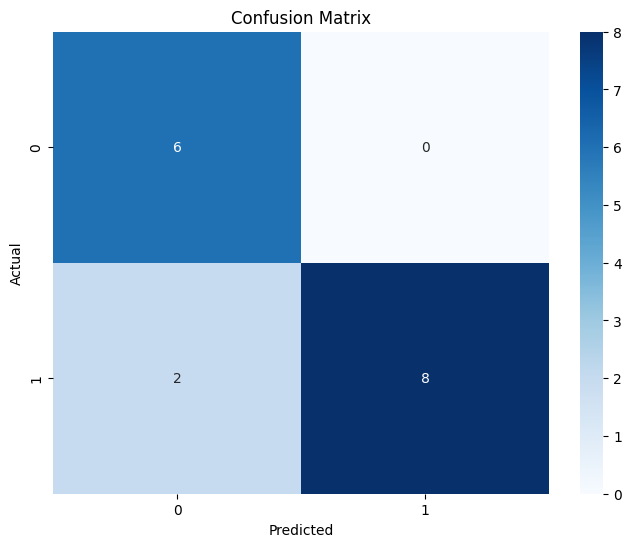

In [ ]:
plot_confusion_matrix(model.predict(X_test), y_test)

## Training best model for more epochs
Using the model found in the previous step, we fit it for longer, in order to see if we get overfitting problems or we find a better local minimum (hopefully the second, but most probably the first, since the model is relatively deep so having it learn for more epochs inevitably will lead to overfitting)

In [ ]:
# import tuner from file if it exists
assert os.path.exists("DL-exam/RandSearchCV"), "First run the code above"
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    directory='DL-exam',
    project_name='RandSearchCV',
    seed=934
)
with open('DL-exam/best_hps.pkl', 'rb') as f:
    best_hps = pk.load(f)
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=1)

Reloading Tuner from DL-exam/RandSearchCV/tuner0.json
Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.3927 - loss: 0.7148 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4865 - loss: 0.7007 - val_accuracy: 0.5862 - val_loss: 0.6799
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5751 - loss: 0.6900 - val_accuracy: 0.7414 - val_loss: 0.6702
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5995 - loss: 0.6802 - val_accuracy: 0.7414 - val_loss: 0.6608
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6569 - loss: 0.6720 - val_accuracy: 0.7759 - val_loss: 0.6517
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7045 - loss: 0.6624 - val_accuracy: 0.7414 - val_loss: 0.6428
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7054 - loss: 0.6495 - val_accuracy: 0.7759 - val_loss: 0.6330
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7338 -

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_first_overcomplete (Dense)        │ (None, 12)                  │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1a (Dense)                        │ (None, 34)                  │             442 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1b (Dense)                        │ (None, 34)                  │           1,190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 34)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 1)                   │              35 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

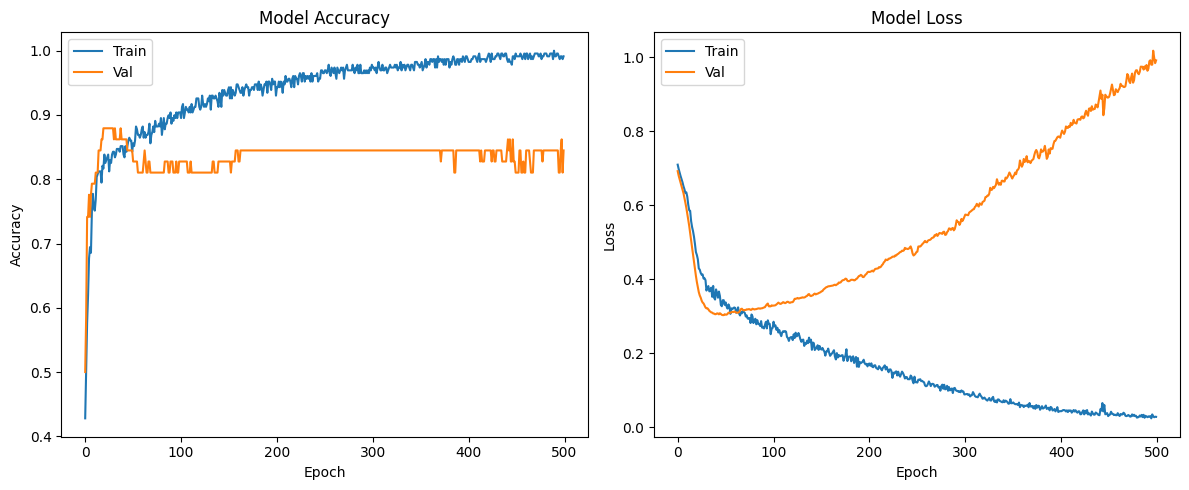

In [ ]:
plot_history(history)

Indeed we get that training for longer than the found number of epochs only leads to overfitting and incapability of generalization.

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - loss: 1.5539


[1.5538766384124756, 0.8125]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


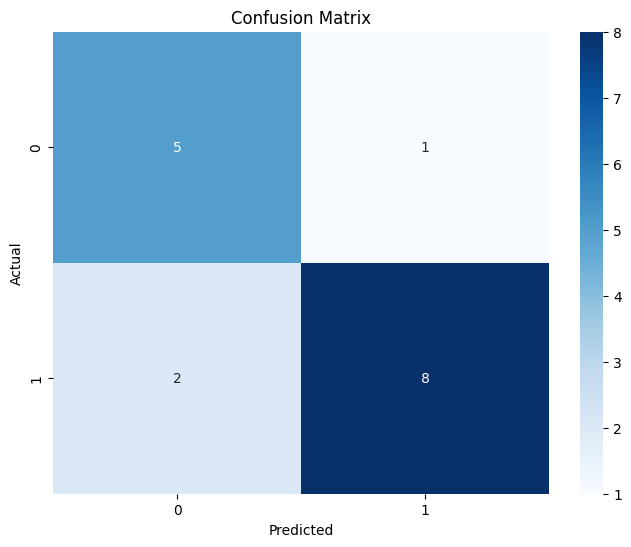

In [ ]:
plot_confusion_matrix(model.predict(X_test), y_test)

In [ ]:
model.save("DL-exam/best_model_500_epochs.keras")

# Inspection

In [ ]:
model = keras.models.load_model("DL-exam/best_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## First Hidden layer analysis
Here we will perform an analysis of the weights in the first hidden layer in order to examine if some units fire larger weights than others. We will group together categorical features and treat them as one, by summing together the rows in the weights matrix associated to the same category. This is possible because in preprocessing I saved a `list_groups` list with the units associated to the same feature

In [ ]:
A, b = model.layers[1].get_weights()

In [ ]:
def most_least_significant(W, b, n=3, list_group = [[]]):
    # Calculate the absolute value of the weights
    weights_cat = []

    # Iterate over each group in list_group
    for group in list_group:
        # Sum the rows corresponding to the indices in the group
        summed_rows = W[group, :].sum(axis=0)
        # Append the result to A_prime
        weights_cat.append(summed_rows)

    for i in range(W.shape[0]):
        if i not in sum(list_group, []):
            weights_cat.append(W[i])

    weights_cat = np.array(weights_cat)
    weights_abs = np.abs(weights_cat)

    weights_sum = weights_abs.sum(axis=1)

    most_significant_indices = np.argsort(weights_sum)[-n:][::-1]
    least_significant_indices = np.argsort(weights_sum)[:n][::-1]

    relative_significance_most = weights_sum[most_significant_indices] / weights_sum.sum()
    relative_significance_least = weights_sum[least_significant_indices] / weights_sum.sum()

    return (most_significant_indices, relative_significance_most), \
           (least_significant_indices, relative_significance_least)

ms, ls = most_least_significant(A, b, n=3, list_group=list_groups)
print("Most Significant Features:")
print("\n".join(f"Feature {i :02} apports {p*100 :04.1f}% of the decision" for i, p in zip(*ms)))
print("Least Significant Features:")
print("\n".join(f"Feature {i :02} apports {p*100 :04.1f}% of the decision" for i, p in zip(*ls)))

Most Significant Features:
Feature 00 apports 12.0% of the decision
Feature 03 apports 11.6% of the decision
Feature 02 apports 10.6% of the decision
Least Significant Features:
Feature 06 apports 05.7% of the decision
Feature 12 apports 05.4% of the decision
Feature 11 apports 04.9% of the decision


So we get that feature 0, 3 and 2 (namely the third, fourth and  
first **categorical** feature, since I've reshuffled them slightly in preprocessing) are the most significant, while features 6, 12, and 11 are the least considered in doing the prediction.

We have though to make a few considerations: we have used L2 regularization (though with small $\lambda$ in the end, so this should not have a big effect) and early stopping, so we required to compromise and keep weights absolute values small, so we get two consequences:
- most weights are going to be small, so it's improbable that few nodes fire a large weight
- most weights are going to be similar, since we only gave 20-30 epochs to find the values, so they are still near to init values
- because of the latter, it's most probable that categorical features, who take up more units in the model, have larger weights associated to them

## Whole model visualization
Here we will plot the whole model and the connections between nodes, while colouring in red the negative weights (which direct the decision towards an answer of 0) and in blue the positive ones (which direct the decision towards 1). We want to see if there is some clear pattern

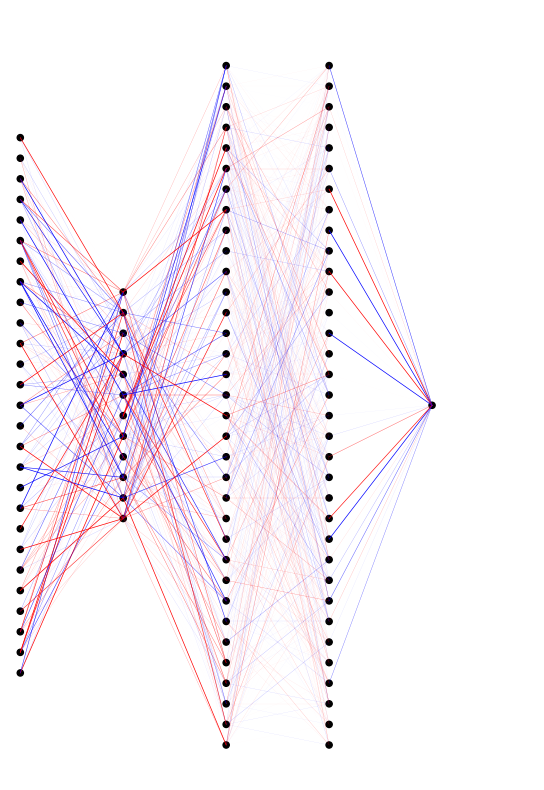

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_weights(model):
    # Get the model layers
    layers = [layer for layer in model.layers if "FC" in layer.name] + [model.layers[-1]]

    # Number of layers and neurons in each layer
    layer_sizes = [layer.input.shape[1] for layer in layers] + [layers[-1].output.shape[1]]

    # Extract weights from each layer
    weights = [layer.get_weights()[0] for layer in layers]  # Only the weight matrices

    # Set up the figure
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_aspect('equal')
    layer_positions = []
    for i, layer_size in enumerate(layer_sizes):
        layer_positions.append([(i * 10, j * 2 - layer_size) for j in range(layer_size)])

    # Plot neurons
    for layer_pos in layer_positions:
        for neuron in layer_pos:
            ax.add_patch(plt.Circle(neuron, 0.3, color='black', fill=True))

    # Plot connections
    for i, (layer_pos_in, layer_pos_out, weight_matrix) in enumerate(zip(layer_positions[:-1], layer_positions[1:], weights)):
        for j, neuron_in in enumerate(layer_pos_in):
            for k, neuron_out in enumerate(layer_pos_out):
                weight = weight_matrix[j, k]

                color = 'red' if weight > 0 else 'blue'
                alpha = min(1, weight**4 * 50) # In order to only show the largest values
                linewidth = alpha/2

                # Draw the connection (line)
                ax.plot([neuron_in[0], neuron_out[0]], [neuron_in[1], neuron_out[1]],
                        color=color, alpha=alpha, linewidth=linewidth)

    ax.set_xlim(-1, len(layer_sizes) * 10)
    ax.set_ylim(-max(layer_sizes) * 1.1, max(layer_sizes) * 1.1)
    ax.axis('off')
    plt.show()

plot_model_weights(model)

As we can see, between the two 34-nodes hidden layers there are a lot of connections, with none of large weight, making it hard to identify any pattern. However we can try to extract information about influence of the input feature by performing an algorithm where we recursively calculate influence in a similar way to what we did for the first hidden layer

## Recursive influence analysis
Here we will calculate the influence of each feature by performing a recursive analysis of the influence of each node in each layer, knowing of course that the node in the final layer has 100% influence.

In order to do that we will actually do something slightly different: the idea is that if we had a simple model with two inputs and one output, and the weights were all equal, then the influence would be equal for those, 50%. Obtaining this consisted of taking the weights and normalizing them in order to get the sum 1.

For any precedent layer than the one-to-last, we will so normalize the matrix of weight so that each weight from nodes $i$ to a specified node $j$ is equal to the influence that we calculated for node $j$. Then the influence of each node $i$ in the domain layer is summed to the others.

In [ ]:
def get_influences(layers, decision=None):
    """Note: here we only have weights from node to all other nodes in
    the next layer, so w is only a vector and not a matrix, but b is still a
    vector, since it's the biases in the next layer"""
    W = layers[0].get_weights()[0]
    if decision is None:
        W = np.abs(W)
    elif decision == 0:
        W = -np.minimum(W, 0)
    elif decision == 1:
        W = np.maximum(W, 0)
    else:
        raise ValueError("Decision must be in [None, 0, 1]")

    W = W / np.sum(W, axis=0, keepdims=True) # normalization, part 1
    if len(layers) == 1:
        return W.flatten()
    cod_influences = get_influences(layers[1:], decision)
    W = W * cod_influences.reshape((1, -1)) # normalization, part 2
    return np.sum(W, axis=1) # sum


In [ ]:
def all_influences(model):
    layers = [layer for layer in model.layers if "FC" in layer.name] + [model.layers[-1]]
    print("Calculating None decisions", end="... ")
    dec_None = get_influences(layers, None)
    print("DONE\nCalculating 1 decisions", end="... ")
    dec_1 = get_influences(layers, 1)
    print("DONE\nCalculating 0 decisions", end="... ")
    dec_0 = get_influences(layers, 0)
    print("DONE")
    return dec_None, dec_1, dec_0

influences = all_influences(model)

Calculating None decisions... DONE
Calculating 1 decisions... DONE
Calculating 0 decisions... DONE


In [ ]:
print(f"Feature {'abs':^7} {1:^7} {0:^7}")
for i, dNone, d1, d0 in zip(range(34), *influences):
    print(f"{i :^7} {dNone*100 :^ 7.2f} {d1*100 :^ 7.2f} {d0*100 :^ 7.2f}")
print(" Total  " + " ".join(f"{d.sum()*100 :^ 7.1f}" for d in influences))

Feature   abs      1       0   
   0      3.07    1.92    3.51 
   1      4.60    5.63    2.78 
   2      3.52    4.75    2.08 
   3      3.29    1.32    4.37 
   4      3.57    6.51    1.67 
   5      4.22    5.51    3.58 
   6      2.66    2.45    2.58 
   7      2.24    2.01    2.00 
   8      4.18    3.10    5.42 
   9      3.47    4.37    4.23 
  10      4.10    2.69    5.72 
  11      3.98    4.20    2.99 
  12      2.36    2.62    1.94 
  13      4.06    3.54    3.91 
  14      3.19    1.70    4.29 
  15      3.28    2.12    4.14 
  16      4.30    7.69    3.00 
  17      4.00    4.62    4.20 
  18      3.83    3.24    3.84 
  19      4.78    4.22    5.82 
  20      3.67    4.08    3.02 
  21      5.19    3.74    5.26 
  22      3.82    2.24    5.66 
  23      4.20    3.89    4.52 
  24      3.83    5.44    3.40 
  25      3.12    3.30    2.14 
  26      3.44    3.08    3.93 
 Total   100.0   100.0   100.0 


Now I will draw an histogram in order to visualize this table in an easier way. I will also add slim bars to indicate the categorical features

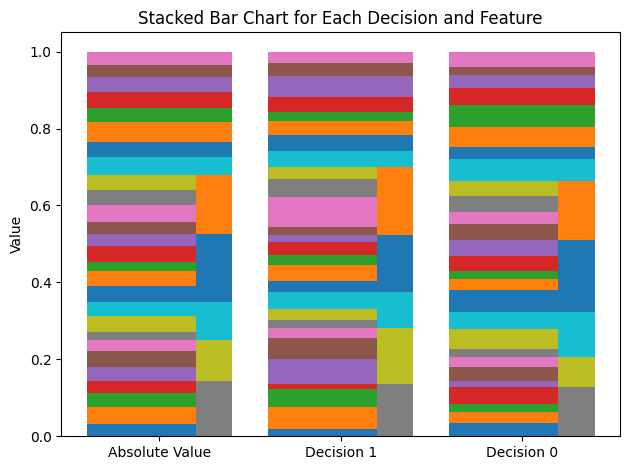

In [183]:
matrix = np.array([influences[0], influences[1], influences[2]]).T
x = np.arange(matrix.shape[1])
fig, ax = plt.subplots()
bottom = np.zeros(matrix.shape[1])
for i in range(matrix.shape[0]):
    ax.bar(x, matrix[i], bottom=bottom)
    bottom += matrix[i]

# add groups for categorical features
bottom = np.zeros(matrix.shape[1])
for i in range(len(list_groups)):
    ax.bar(x+.2, np.sum(matrix[list_groups[i]], axis=0), bottom=bottom, \
           width=.2, align='edge', label=f'Feature {i}')
    bottom += np.sum(matrix[list_groups[i]], axis=0)

ax.set_xticks(x)
ax.set_xticklabels(['Absolute Value', 'Decision 1', 'Decision 0'])
ax.set_ylabel('Value')
ax.set_title('Stacked Bar Chart for Each Decision and Feature')

plt.tight_layout()
plt.show()

As we can see there isn't any feature that is particularly dominant. There are though some who have slightly more or less influence. For example feature 16 (middle lilac band) has a big influence, in particular in deciding 1. This means (in particular if it were more accentuated) that we have reason to think that if the outcome of the model is 1 then probably 16 is 1 instead of 0 (it's part of a one-hot encoded feature).

Another observation is that Feature 1 (seeing it as categorical, so feature 0 to 3) has an appearent influence on the decision: indeed it seems as though when the outcome of the model is 1 it's more likely that the value is either 1 or 2, while when the outcome is 0 it's more likely that the value is either 0 or 3